# Amazon Food Reviews - KNN Implementation - by Shobhit Gupta

# 1) Introduction 

In this notebook, we will be performing polarity prediction of of a given food review text by applying KNN (K- Nearest Neigbour) algorithm. Before building the prediction model, first step is to clean the data as a part of data-preprocessing.

We will perform following data preprocessing.

-- Removing Stop-words

-- Remove any punctuations or limited set of special characters.

-- Removing HTML tags

-- Stemming the word using Snowball Stemming

-- Converting the words to lowercase

### Objective: Given a review, determine whether it is +ve or -ve using KNN - algorithm and find the accuracy of the model

# 2) Pre-processing and cleaning of data

In [2]:
# ============================== loading libraries for KNN ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
# =============================================================================================

C:\Users\Shobhit\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# ======================== Loading libraries for pre-processing ====================================== #

%matplotlib inline

import sqlite3
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# ==================================================================================================== #

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('C:/Users/Shobhit/Desktop/amazon-fine-food-reviews/database.sqlite')

filtered_data = pd.read_sql_query("""Select * from Reviews WHERE Score != 3""",con)

filtered_data.shape

(525814, 10)

In [5]:
# Assigning positive(4,5) and negative(1,2) to review Scores

def posneg(x):
    if x == 5 or x == 4:
        return "positive"
    return "negative"

actScore = filtered_data['Score']
pn = actScore.map(posneg)   #converting into 'positive' and 'negative'
filtered_data['Score'] = pn

In [6]:
final_pos = filtered_data[filtered_data['Score'] == 'positive']
final_pos = final_pos.sample(frac=0.07,random_state=1)

final_neg = filtered_data[filtered_data['Score'] == 'negative']
final_neg = final_neg.sample(frac=0.3,random_state=1)

final = pd.concat([final_pos,final_neg],axis=0)

In [7]:
final.shape

(55675, 10)

In [7]:
final['Score'].value_counts()

positive    31064
negative    24611
Name: Score, dtype: int64

#### Observation(s):

-- Sample is almost balanced.

#### Note: Due to memory restrictions, I have taken a sample of 55k records

In [8]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
It is all about the right mixture and the better way to brew a nice cup of coffee. We add lots of hot milk to it and make out own latte. This coffee is our espresso replacement and tastes so good! It is a coffee our European visitors really appreciate.<br />There are 2 reasons to prefer it over Starbucks, it is heck of a lot cheaper and it tastes at least as good (to me).


In [9]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{'during', 'most', 'below', 'itself', 'over', 'above', 'too', 'again', 'own', 'it', 'than', 'were', 'between', 'i', 'ours', 'why', "shouldn't", 'here', 'doesn', 'themselves', 'such', 'what', "wasn't", 'until', 'her', 'needn', 'once', 'd', "haven't", 'and', 'am', 'having', 'does', 's', 'in', 'of', 'are', 'which', "won't", 'down', "mightn't", "she's", 'me', 'as', 'doing', "you'd", 'so', 'wouldn', 'you', 'have', 'didn', 'with', 'has', 'not', 'isn', "isn't", 'more', 'they', 'hasn', 'for', 'further', 't', 'now', 'by', 'if', 'about', "it's", 'yours', 'against', 'will', "mustn't", 'all', 'we', 'its', 'whom', 'o', "doesn't", 'just', "didn't", 'up', 'hadn', 'shan', 'do', 'your', 'very', 'an', "don't", 'from', 'both', 'a', 'mightn', 'him', 'did', 'this', 'shouldn', "you're", 'to', "needn't", 'mustn', 'ain', 'while', 'll', 'few', 'myself', 'these', 'out', 'then', 'other', 'after', 'that', 'each', 'y', 'm', 'into', 'being', 'nor', 'through', 're', 'them', 'at', 'before', 'wasn', "you'll", 'or', 'o

In [10]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

# 3) Sorting data based on time

In [11]:
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)  #Sorting the data and resetting the index

In [13]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
1,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
2,149789,B00004S1C6,A1KXONFPU2XQ5K,Stephanie Manley,26,28,positive,965779200,A must have!,"These are easy to use, they do not make a mess..."
3,451935,B00004CXX9,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,positive,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...
4,230284,B00004RYGX,A1HWMNSQF14MP8,will@socialaw.com,1,2,positive,978134400,A Afterlife Success,"Many movies, have dealt with the figure of dea..."


#### Observation(s):

-- Stopwords are removed.

-- Special characters and HTML tags are removed

-- Stemming is done using Snowball Stemmer.

-- Words are converted to lowercase.

-- Sample is sorted on the basis of timestamp in ascending order.

# 4) Splitting the cleaned data into Train and Test

In [12]:
#Splitting data into Train and test - 70% Train, 30 % test
import math

X = final
y = final['Score']

X_train =  final[:math.ceil(len(final)*.7)] 
X_test = final[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38973, 10)
(16702, 10)
(38973,)
(16702,)


### 5 fold CV 

In [16]:
def find_optimal_k(X_train,y_train):
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 5-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')


    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

# 5) Vectorization and Model Building

## 5.1) KNN with BOW 

In [17]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
X_train_counts = count_vect.fit_transform(X_train['Text'].values)
X_test_counts = count_vect.transform(X_test['Text'].values)

In [18]:
print(X_train_counts.shape)
print(X_test_counts.shape)

(38973, 37043)
(16702, 37043)



The optimal number of neighbors is 9.
the misclassification error for each k value is :  [0.352 0.341 0.34  0.339 0.333 0.333 0.333 0.333 0.333 0.333 0.333 0.335
 0.335 0.335 0.333 0.334 0.334 0.337 0.337 0.34  0.34  0.341 0.341 0.341
 0.341]


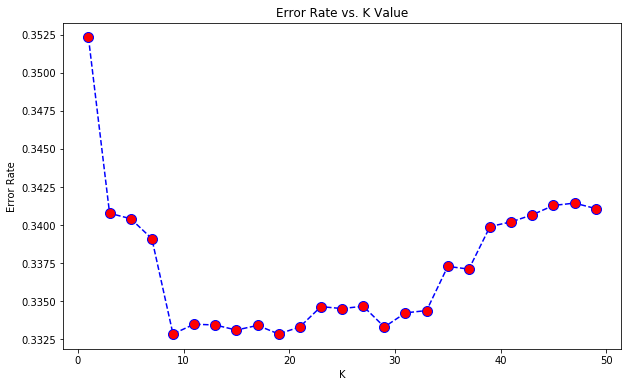

In [19]:
optimal_k = find_optimal_k(X_train_counts ,y_train)

In [20]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_counts, y_train)

# predict the response
pred = knn_optimal.predict(X_test_counts)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 9 is 64.782661%


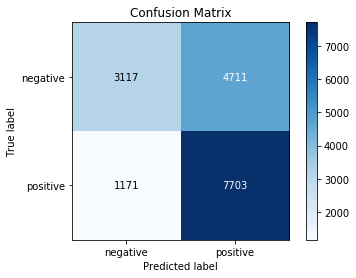

In [21]:
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
skplt.plot_confusion_matrix(y_test ,pred)

In [22]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.73      0.40      0.51      7828
   positive       0.62      0.87      0.72      8874

avg / total       0.67      0.65      0.63     16702



#### Observations(s):

-- Train data is fitted and transformed over the vectorizer.

-- Test data is transformed accordingly.

-- Error rate is lowest when K = 9. Hence, 9 is the optimal K.

-- Using BOW as the vectorizer and K = 9, we get an accuracy of ~ 64%.

-- From the confusion matrix, we infer that out of 16,702 data points in our test data set, 10,820 are classified correctly.

## 5.2) KNN with TF-IDF

In [23]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train_tfidf = tf_idf_vect.fit_transform(X_train['Text'].values)
X_test_tfidf = tf_idf_vect.transform(X_test['Text'].values)

In [24]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(38973, 635807)
(16702, 635807)



The optimal number of neighbors is 45.
the misclassification error for each k value is :  [0.307 0.283 0.271 0.263 0.256 0.252 0.248 0.242 0.241 0.234 0.233 0.231
 0.228 0.226 0.225 0.226 0.224 0.224 0.221 0.221 0.218 0.219 0.218 0.219
 0.218]


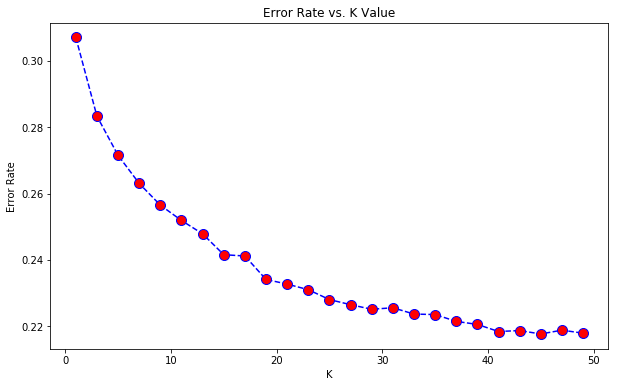

In [25]:
optimal_k = find_optimal_k(X_train_tfidf ,y_train)

In [26]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train_tfidf, y_train)

# predict the response
pred = knn_optimal.predict(X_test_tfidf)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 45 is 77.793079%


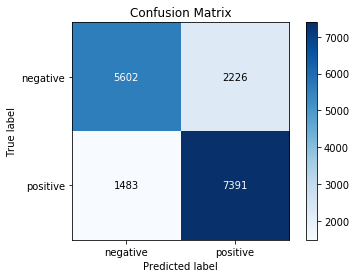

In [27]:
skplt.plot_confusion_matrix(y_test ,pred)  #Plotting confusion matrix

In [28]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.79      0.72      0.75      7828
   positive       0.77      0.83      0.80      8874

avg / total       0.78      0.78      0.78     16702



#### Observations(s):

-- Train data is fitted and transformed over the vectorizer.

-- Test data is transformed accordingly.

-- Error rate is lowest when K = 45. Hence, 45 is the optimal K.

-- Using BOW as the vectorizer and K = 45, we get an accuracy of ~ 78%.

-- From the confusion matrix, we infer that out of 16,702 data points in our test data set, 12,993 are classified correctly.

## 5.3) KNN with Average Word2Vec

In [29]:
# Train your own Word2Vec model using your own text corpus - Train dataset
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
i=0
list_of_sent=[]
for sent in X_train['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

C:\Users\Shobhit\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [30]:
# Train your own Word2Vec model using your own text corpus - Test dataset
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
i=0
list_of_sent_t=[]
for sent in X_test['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_t.append(filtered_sentence)

In [31]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

w2v_model_t=gensim.models.Word2Vec(list_of_sent_t,min_count=5,size=50, workers=4)

In [32]:
# Performing Average W2V for Train data

sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [33]:
# Performing Average W2V for Test data

sent_vectors_t = []; 
for sent in list_of_sent_t: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model_t.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_t.append(sent_vec)

In [34]:
from sklearn.preprocessing import StandardScaler

k = StandardScaler()
final_w2v_train = k.fit_transform(sent_vectors)
final_w2v_test = k.transform(sent_vectors_t)


The optimal number of neighbors is 45.
the misclassification error for each k value is :  [0.288 0.26  0.245 0.237 0.232 0.228 0.225 0.222 0.218 0.218 0.214 0.214
 0.215 0.214 0.212 0.212 0.212 0.211 0.21  0.211 0.21  0.21  0.209 0.209
 0.209]


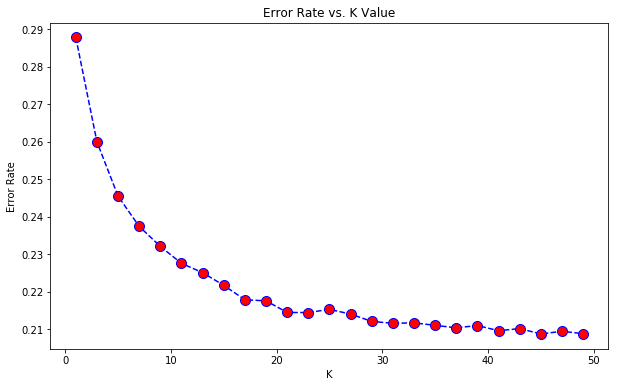

In [35]:
optimal_k = find_optimal_k(final_w2v_train ,y_train)

In [36]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(final_w2v_train, y_train)

# predict the response
pred = knn_optimal.predict(final_w2v_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 45 is 66.620764%


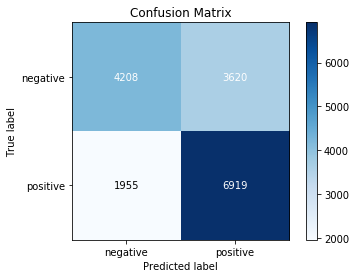

In [37]:
skplt.plot_confusion_matrix(y_test ,pred)  #Plotting confusion matrix

In [38]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.68      0.54      0.60      7828
   positive       0.66      0.78      0.71      8874

avg / total       0.67      0.67      0.66     16702



#### Observations(s):

-- Train data is fitted and transformed over the vectorizer.

-- Test data is transformed accordingly.

-- Error rate is lowest when K = 45. Hence, 45 is the optimal K.

-- Using BOW as the vectorizer and K = 45, we get an accuracy of ~ 66%.

-- From the confusion matrix, we infer that out of 16,702 data points in our test data set, 11,127 are classified correctly.

## 5.4) KNN with TF-IDF Word2Vec

In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = X_train_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_t = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_t: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_t.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = X_test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_t.append(sent_vec)
    row += 1

In [44]:
final_tf_train = StandardScaler().fit_transform(tfidf_sent_vectors)
final_tf_test = StandardScaler().transform(tfidf_sent_vectors_t)


The optimal number of neighbors is 45.
the misclassification error for each k value is :  [0.312 0.285 0.27  0.262 0.26  0.255 0.249 0.244 0.243 0.242 0.241 0.24
 0.239 0.237 0.237 0.235 0.235 0.234 0.233 0.232 0.231 0.231 0.231 0.231
 0.231]


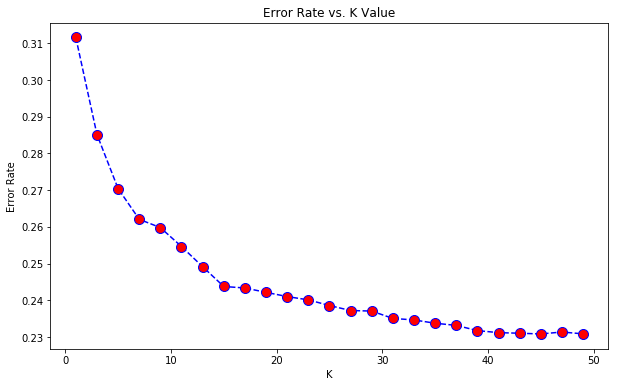

In [45]:
optimal_k = find_optimal_k(final_tf_train ,y_train)

In [46]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(final_tf_train, y_train)

# predict the response
pred = knn_optimal.predict(final_tf_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier using brute for k = 45 is 70.003592%


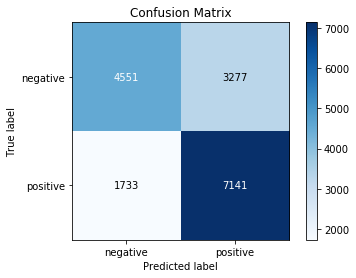

In [47]:
skplt.plot_confusion_matrix(y_test ,pred)  #Plotting confusion matrix

In [48]:
print(classification_report(y_test ,pred))

             precision    recall  f1-score   support

   negative       0.72      0.58      0.64      7828
   positive       0.69      0.80      0.74      8874

avg / total       0.70      0.70      0.70     16702



#### Observations(s):

-- Train data is fitted and transformed over the vectorizer.

-- Test data is transformed accordingly.

-- Error rate is lowest when K = 45. Hence, 45 is the optimal K.

-- Using BOW as the vectorizer and K = 45, we get an accuracy of ~ 70%.

-- From the confusion matrix, we infer that out of 16,702 data points in our test data set, 11,692 are classified correctly.

# Conclusion(s) / Summary:

### Overall flow:

####  1) Importing required libraries. 

#### 2) Connect with SQL database, get the +ve and -ve data and store it in a dataframe. 

#### 3)  Sample it so as to get a balanced data set. 

#### 4) Apply pre-processing techniques to clean and standardize. 

#### 5) Sort it according to timestamp. 

#### 6) Perform time based splitting into train and test in the ratio 70:30. 

#### 7) Apply all four vectorizer methods (BOW, TF-IDF, Avg Word2vec and TF-IDF Word2Vec) to convert text into vectors.

#### 8) For each vectorizer method, we find the optimal K value and train our model using that value.

#### 9) Perform prediction on test data.

#### 10) Get Error graph, Confusion matrix and classification report.

### Others:

#### a) Out of all 4 vectorizers, KNN performs best on TF-IDF with an accuracy of 78%.

#### b) Confusion matrix gives us an easy interpretation of how well our model predicted class labels.

#### c) Conclusion table:

| Model | Best K | Total +ve points | Total -ve points | Predicted +ve points | Predicted -ve points | Accuracy |
|-------|--------|--------------|-------------|-------------|------------|
|   BOW | 9| 8874 | 7828 | 7703 | 3117 | 0.64 |
|   TF-IDF | 45 | 8874 | 7828 | 7391 | 5602 | 0.78
|   Avg W2V | 45 | 8874 | 7828 | 6919 | 4208 | 0.67
| TF-IDF W2V | 45 | 8874 | 7828 | 7141 | 4551 | 0.70